## Общая информация

**Срок сдачи:** 5 апреля 2022, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
# дефолтная функция расстояния в KNeighborsClassifier
from sklearn.metrics.pairwise import euclidean_distances
# KDTree
from sklearn.neighbors import KDTree
# функция нахождения моды выборки
from scipy import stats

class MyKNeighborsClassifier(BaseEstimator):
    
    def _fit_brute(self):
        pass
    
    def _predict_brute(self, X):
        distances = euclidean_distances(X, self.X_train)
        indices = np.argpartition(distances, kth=self.n_neighbors, axis=1)
        return indices[:, :self.n_neighbors]
    
    def _fit_kdtree(self):
        self._tree = KDTree(self.X_train, 30, metric='euclidean')
    
    def _predict_kdtree(self, X):
        indices = self._tree.query(X, k=self.n_neighbors, return_distance=False)
        return indices[:, :self.n_neighbors]

    _KNN_SUPPORTED_ALGORITHMS = {
        "brute": {"fit": _fit_brute, "predict": _predict_brute},
        "kd_tree": {"fit": _fit_kdtree, "predict": _predict_kdtree},
    }
    
    def _initcheck(self):
        if self.n_neighbors < 1:
            raise ValueError(f"n_neighbors (={self.n_neighbors}) should be a positive integer!")
        if self.algorithm not in self._KNN_SUPPORTED_ALGORITHMS:
            raise ValueError(f"Algorithm {self.algorithm} isn't supported!")

    def __init__(self, n_neighbors: int = 1, algorithm="brute"):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self._initcheck()
        self._effective_algorithm = self._KNN_SUPPORTED_ALGORITHMS[self.algorithm]
    
    def fit(self, X, y):
        if self.n_neighbors > X.shape[0]:
            raise ValueError(f"neighbors: {self.n_neighbors} > samples: {X.shape[0]}")
        if X.shape[0] != y.shape[0]:
            raise ValueError(f"data samples: {X.shape[0]} != target samples: {y.shape[0]}")
        self.X_train = X.copy()
        self.y_train = y.copy()
        self._effective_algorithm["fit"](self)
    
    def predict(self, X):
        if self.X_train.shape[1:] != X.shape[1:]:
            raise ValueError(f"Train features {self.X_train.shape} doesn't match {X.shape}")
        indices = self._effective_algorithm["predict"](self, X)
        neibs = self.y_train[indices[:, :self.n_neighbors]]
        y_pred = stats.mode(neibs, axis=1)[0]
        return y_pred.reshape((-1, ))
    


**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 2 (0.5 балла)

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [9]:
%time clf.fit(X_train, y_train)

CPU times: user 429 µs, sys: 0 ns, total: 429 µs
Wall time: 307 µs


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [10]:
%time my_clf.fit(X_train, y_train)

CPU times: user 38 µs, sys: 0 ns, total: 38 µs
Wall time: 31 µs


In [11]:
%time clf.predict(X_test)

CPU times: user 0 ns, sys: 1.52 ms, total: 1.52 ms
Wall time: 1.19 ms


array([1, 2, 0, 0, 1, 0, 2, 0, 1, 1, 0, 2, 1, 2, 2])

In [12]:
%time my_clf.predict(X_test)

CPU times: user 874 µs, sys: 244 µs, total: 1.12 ms
Wall time: 874 µs


array([1, 2, 0, 0, 1, 0, 2, 0, 1, 1, 0, 2, 1, 2, 2])

### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [13]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [15]:
%time clf.fit(X_train, y_train)

CPU times: user 730 µs, sys: 0 ns, total: 730 µs
Wall time: 679 µs


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [16]:
%time my_clf.fit(X_train, y_train)

CPU times: user 267 µs, sys: 74 µs, total: 341 µs
Wall time: 234 µs


In [17]:
%time clf.predict(X_test)

CPU times: user 1.66 ms, sys: 0 ns, total: 1.66 ms
Wall time: 1.4 ms


array([2, 1, 0, 0, 0, 1, 2, 0, 2, 2, 1, 0, 1, 1, 1])

In [18]:
%time my_clf.predict(X_test)

CPU times: user 1.05 ms, sys: 0 ns, total: 1.05 ms
Wall time: 851 µs


array([2, 1, 0, 0, 0, 1, 2, 0, 2, 2, 1, 0, 1, 1, 1])

In [19]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 4 (2.5 балла)

Рассмотрим новый датасет 20 newsgroups

In [20]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [21]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [22]:
# векторайзеры текста
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vec_count = CountVectorizer(min_df = 1, max_df = 400, ngram_range=(1, 1))
vec_tfidf = TfidfVectorizer(min_df = 1, max_df = 400, ngram_range=(1, 1))
X_count = vec_count.fit_transform(data)
X_tfidf = vec_tfidf.fit_transform(data)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [23]:
# кросс-валидация
from sklearn.model_selection import cross_val_score

clf = KNeighborsClassifier(n_neighbors=1, algorithm='brute')
my_metrics = {'euclidean', 'cosine'}
folds = 3

for metric in my_metrics:
    clf.set_params(metric=metric)
    score_count = cross_val_score(clf, X_count, target, cv=folds).mean()
    score_tfidf = cross_val_score(clf, X_tfidf, target, cv=folds).mean()
    print(f"Metrics: {metric}\n"
          f"Count score: {100 * score_count : .2f}%\n"
          f"Tfidf score: {100 * score_tfidf : .2f}%\n"
         )


Metrics: euclidean
Count score:  28.33%
Tfidf score:  13.66%

Metrics: cosine
Count score:  57.05%
Tfidf score:  61.69%



Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [24]:
def find_optimal_neighbors(X, y, search_range, folds=3):
    """поиск оптимального количества ближайших соседей"""
    opt_k = 1
    opt_score = 0.0
    clf = KNeighborsClassifier(n_neighbors=1, algorithm='brute', metric='cosine', n_jobs=-1)
    for k in search_range:
        clf.set_params(n_neighbors=k)
        score = cross_val_score(clf, X, target, cv=folds, n_jobs=-1).mean()
        if score >= opt_score:
            opt_k, opt_score = k, score
        #print(f"k: {k}, score: {score:.2f}%")
    return opt_k, opt_score
    

In [30]:
# пример работы
search_range = range(1, 31, 1)
optimal = find_optimal_neighbors(X_tfidf, target, search_range, folds)
print(f"Search range: {search_range}\n"
      f"Optimal K: {optimal[0]}\n"
      f"Score: {100 * optimal[1]:.2f}%")

Search range: range(1, 31)
Optimal K: 24
Score: 67.66%


In [31]:
# подсчёт графика зависимости средней точности от кол-ва соседей
graph = np.empty(search_range.stop, dtype=tuple)
clf = KNeighborsClassifier(n_neighbors=1, algorithm='brute', metric='cosine')
for k in search_range:
    clf.set_params(n_neighbors=k)
    graph[k] = cross_val_score(clf, X_tfidf, target, cv=folds, n_jobs=-1).mean()

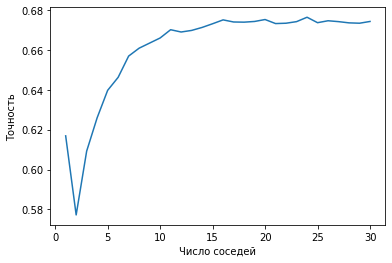

In [32]:
# рисуем график
plt.plot(graph)
plt.xlabel("Число соседей")
plt.ylabel("Точность")
plt.show()

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [33]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [34]:
# набор (tfidf, cosine, max_df=400) даёт точность выше, чем дефолтные
X_test = vec_tfidf.transform(newsgroups['data'])
y_test = newsgroups['target']

clf = KNeighborsClassifier(n_neighbors=optimal[0], algorithm='brute', metric='cosine', n_jobs=-1)
clf.fit(X_tfidf, target)

y_pred = clf.predict(X_test)

score_train = optimal[1]
score_test = accuracy_score(y_test, y_pred)
print(f"Точность\n"
      f" train: {100 * score_train:.2f}%\n"
      f" test: {100 * score_test:.2f}%")

Точность
 train: 67.66%
 test: 63.33%
